In [1]:
import numpy as np
import pandas as pd
from scipy.stats import binom
from scipy.stats import uniform
import seaborn as sns
import matplotlib.pyplot as plt
import arviz as az
import pymc as pm
import arviz
import xarray as xr

    from sklearn.linear_model import LinearRegression

import statsmodels as sm
from sklearn.model_selection import train_test_split        # train and test split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import explained_variance_score
import plotly.express as px

import bambi as bmb
seed = 73073

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

## Simple (one variable) linear regression

In [3]:
df=pd.read_csv('advertising.csv')
df=df.drop('Unnamed: 0',axis=1)
df
#df=pd.read_csv('ads_all.csv')
#df
#df=df.drop('Unnamed: 0',axis=1)
# df_new=df[["ads","sales"]]
# df_new
# df_new.to_csv('ads_all.csv', index=False)

TV Ad Budget  Radio Ad Budget  Newspaper Ad Budget   Sales
0           230.1             37.8                 69.2  1105.0
1            44.5             39.3                 45.1   520.0
2            17.2             45.9                 69.3   465.0
3           151.5             41.3                 58.5   925.0
4           180.8             10.8                 58.4   645.0
..            ...              ...                  ...     ...
195          38.2              3.7                 13.8   380.0
196          94.2              4.9                  8.1   485.0
197         177.0              9.3                  6.4   640.0
198         283.6             42.0                 66.2  1275.0
199         232.1              8.6                  8.7   670.0

[200 rows x 4 columns]

In [4]:
fig = px.scatter(df, x='TV Ad Budget', y='Sales', title='Sales vs. TV ad budget')
fig.show()

## Classical linear regression

In [48]:
x= df.iloc[:, 0:1].values
y = df.iloc[:, -1].values
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)

In [49]:
np.shape(x_train)

(140, 1)

In [50]:
lr = LinearRegression()
lr.fit(x_train, y_train)

LinearRegression()

In [51]:
print('b1',lr.coef_,'b0',lr.intercept_)

b1 [2.29071711] b0 365.5405082705841


In [52]:
ytest_pred = lr.predict(x_test)


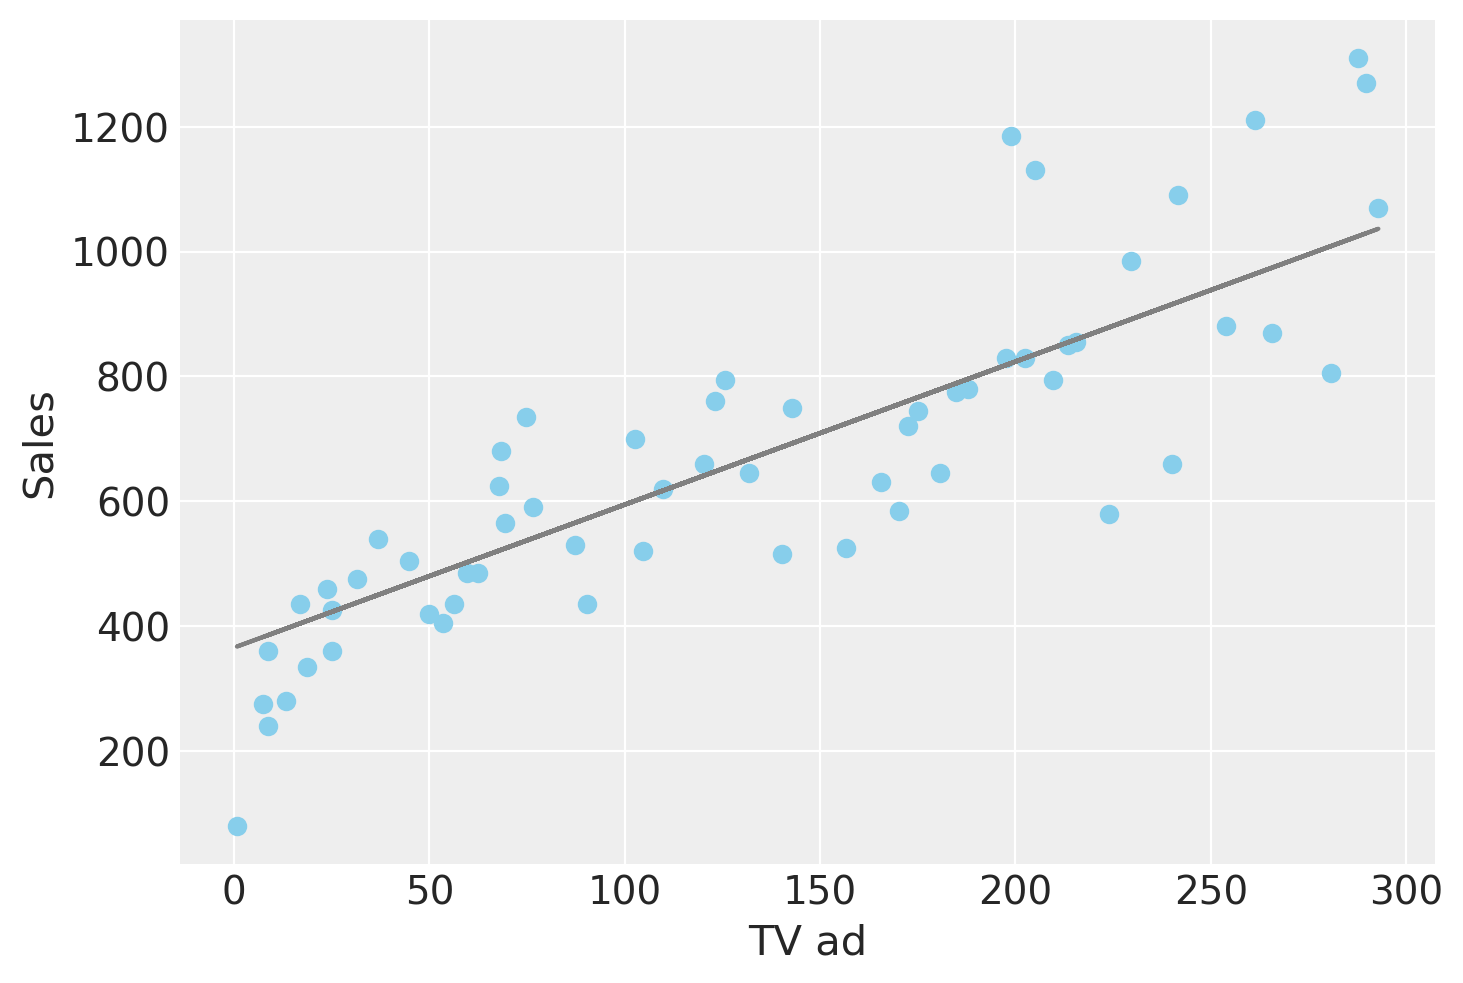

In [53]:
plt.plot(x_test, ytest_pred, color = 'grey')
plt.scatter(x_test, y_test, color = 'skyblue')
plt.title('')
plt.xlabel('TV ad')
plt.ylabel('Sales')
plt.show()


## Bayesian linear regression

In [89]:
# # Standardization
# x = df.iloc[:, 0:1] # TV ads
# y = df.iloc[:, -1:] # sales

# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)

# stdscaler_x = StandardScaler()
# x_train=stdscaler_x.fit_transform(x_train)
# x_test=stdscaler_x.transform(x_test)
# print(np.shape(x_train))
# x_train=x_train.reshape(np.shape(x_train)[0])
# x_test=x_test.reshape(np.shape(x_test)[0])

# stdscaler_y = StandardScaler()
# y_train=stdscaler_y.fit_transform(y_train)
# y_test=stdscaler_y.transform(y_test)
# y_train=y_train.reshape(np.shape(y_train)[0])
# y_test=y_test.reshape(np.shape(y_test)[0])

# data_train = pd.DataFrame(dict(x=x_train, y=y_train),dtype=float)
# data_test = pd.DataFrame(dict(x=x_test, y=y_test),dtype=float)

# data_train


In [5]:
# No Standardization
x = df.iloc[:, 0] # TV ads
y = df.iloc[:, -1] # sales

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)

data_train = pd.DataFrame(dict(x=x_train, y=y_train),dtype=float)
data_test = pd.DataFrame(dict(x=x_test, y=y_test),dtype=float)


data_train

x       y
131  265.2   635.0
96   197.6   585.0
181  218.5   610.0
19   147.3   730.0
153  171.3   950.0
..     ...     ...
67   139.3   670.0
192   17.2   295.0
117   76.4   470.0
47   239.9  1160.0
172   19.6   380.0

[140 rows x 2 columns]

In [6]:
fig = px.scatter(data_train, x='x', y='y', title='Sales vs. TV ad budget')
fig.show()

In [7]:
with pm.Model() as model1:
    # prior distributions: Gaussian with very large variance
    intercept = pm.Normal('Intercept', 0, 1000) # model b0 - Intercept Prior
    slope = pm.Normal('slope', 0, 1000)         # model b1 - Slope Prior 
    sigma = pm.HalfNormal('sigma', 1000)        # standard deviation
    x = pm.MutableData("x", data_train["x"])   
    # specify the model, linear regression
    mu = intercept + slope * x             # estimate of model
    y_obs= data_train["y"]
    # define the distribution of the predictions from the model and provide the data
    likelihood = pm.Normal('y', mu = mu, sigma = sigma, observed = y_obs, shape=mu.shape) # Observed values
    
    trace1=pm.sample(1000, chains=2, cores=2)
    
    # Calculating log-likelihood and sample_prior_predictive
#     pm.compute_log_likelihood(trace1)
#     trace1.extend(pm.sample_prior_predictive())
#     trace1.extend(pm.sample_posterior_predictive(trace1,extend_inferencedata=True))
    
pm.summary(trace1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Intercept, slope, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 57 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


mean      sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
Intercept  367.013  31.905  309.743  427.333      1.057    0.748     910.0   
slope        2.281   0.185    1.953    2.652      0.006    0.004     957.0   
sigma      174.919  10.305  155.934  194.108      0.297    0.215    1306.0   

           ess_tail  r_hat  
Intercept     744.0    1.0  
slope         694.0    1.0  
sigma        1143.0    1.0

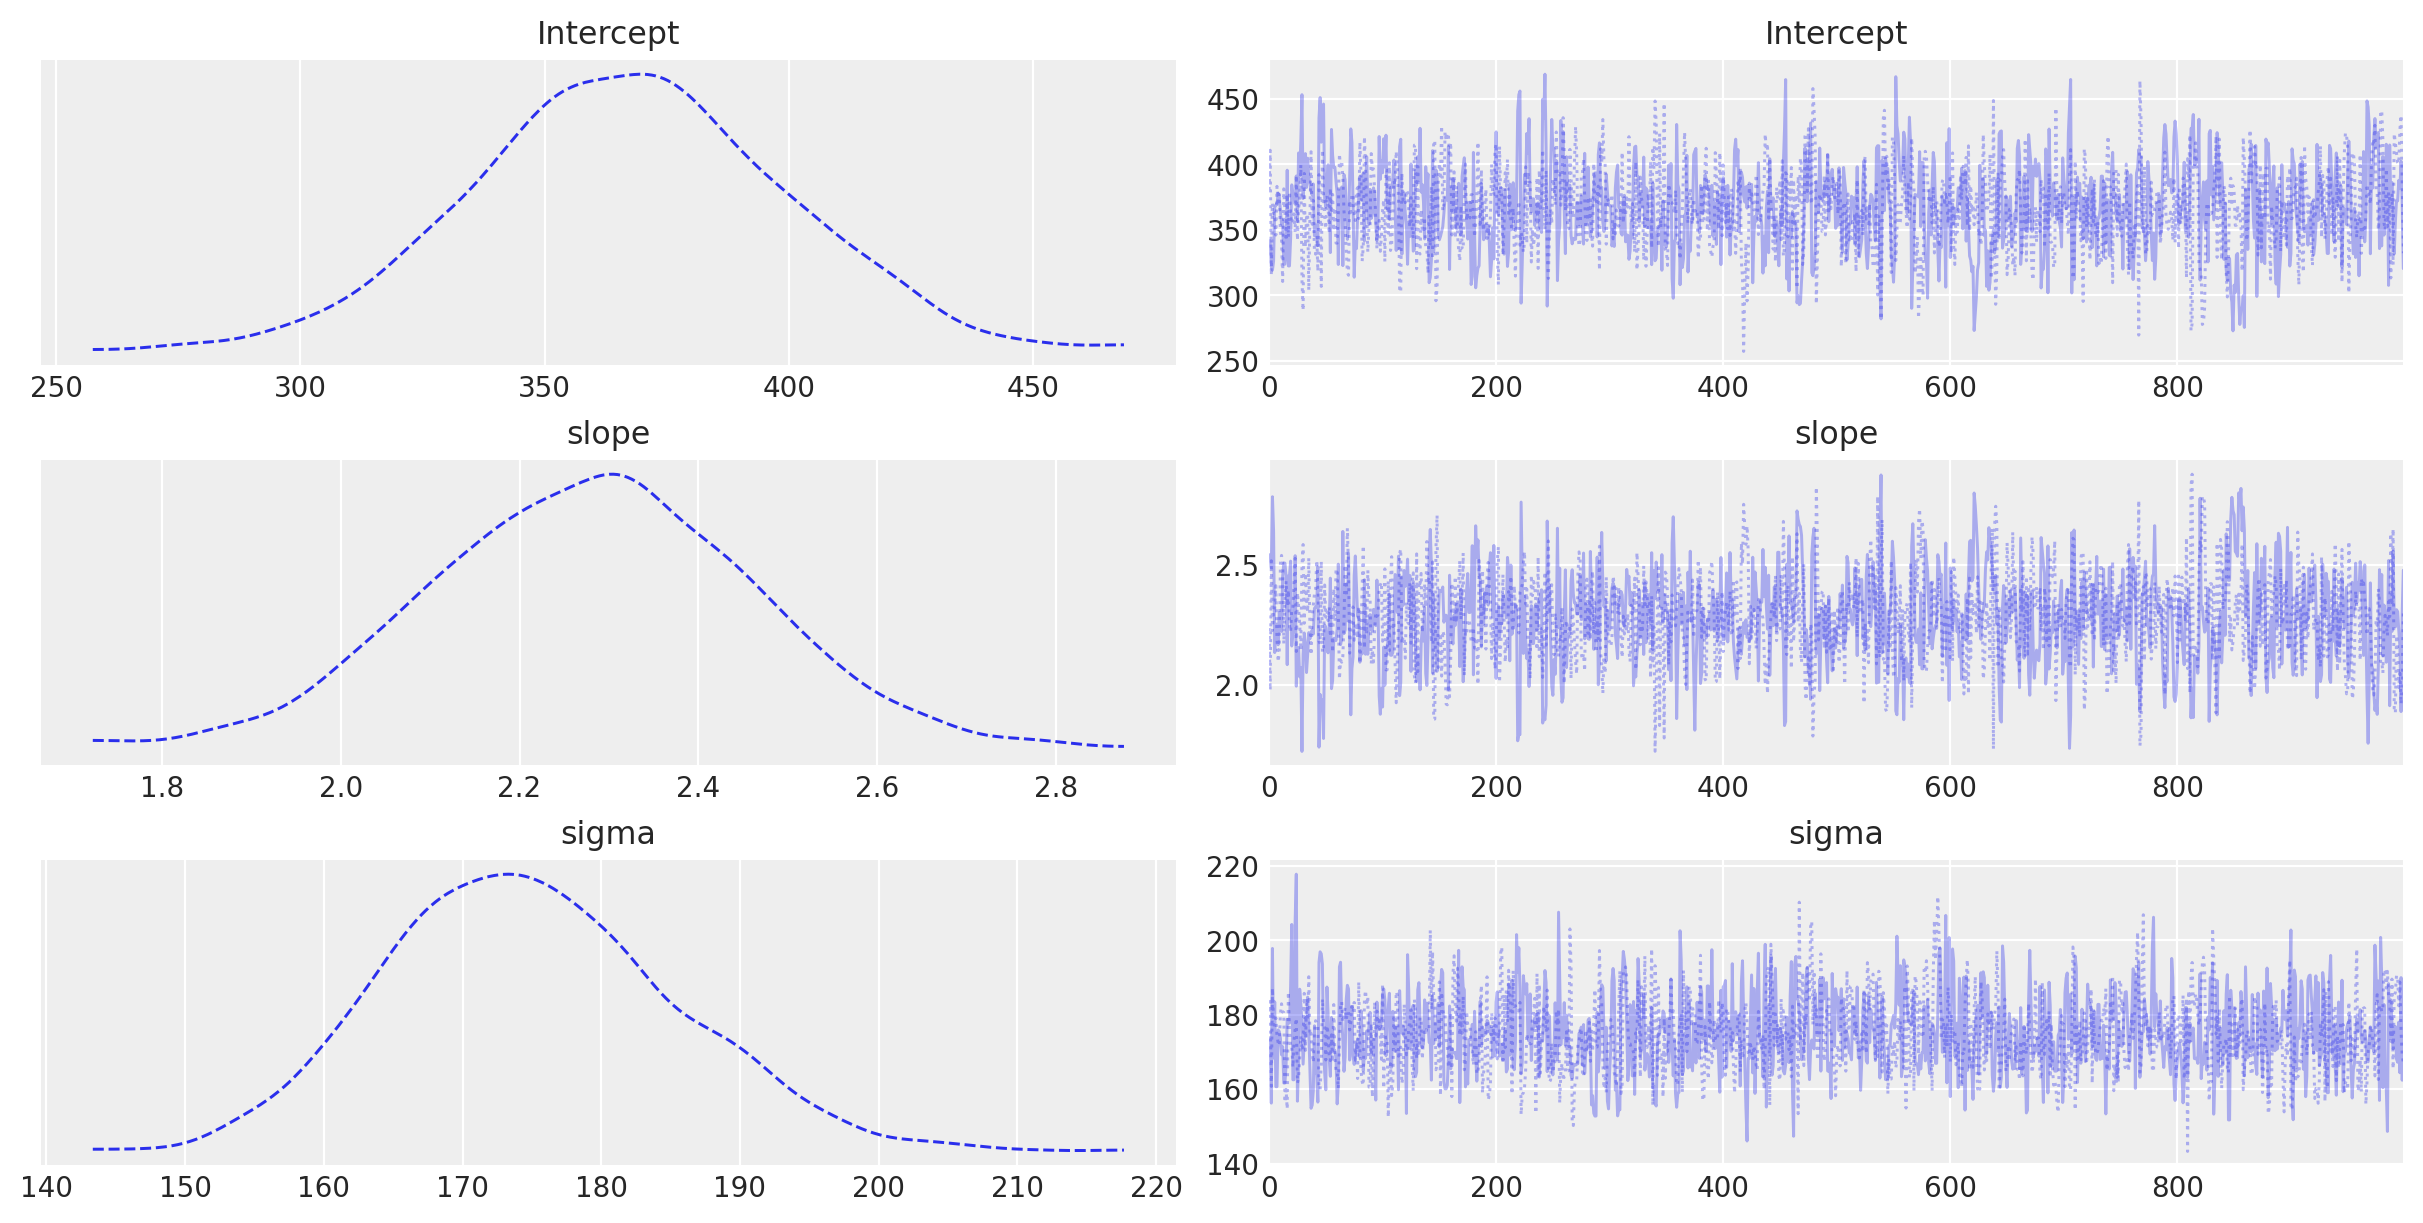

In [8]:
az.plot_trace(trace1, combined=True);

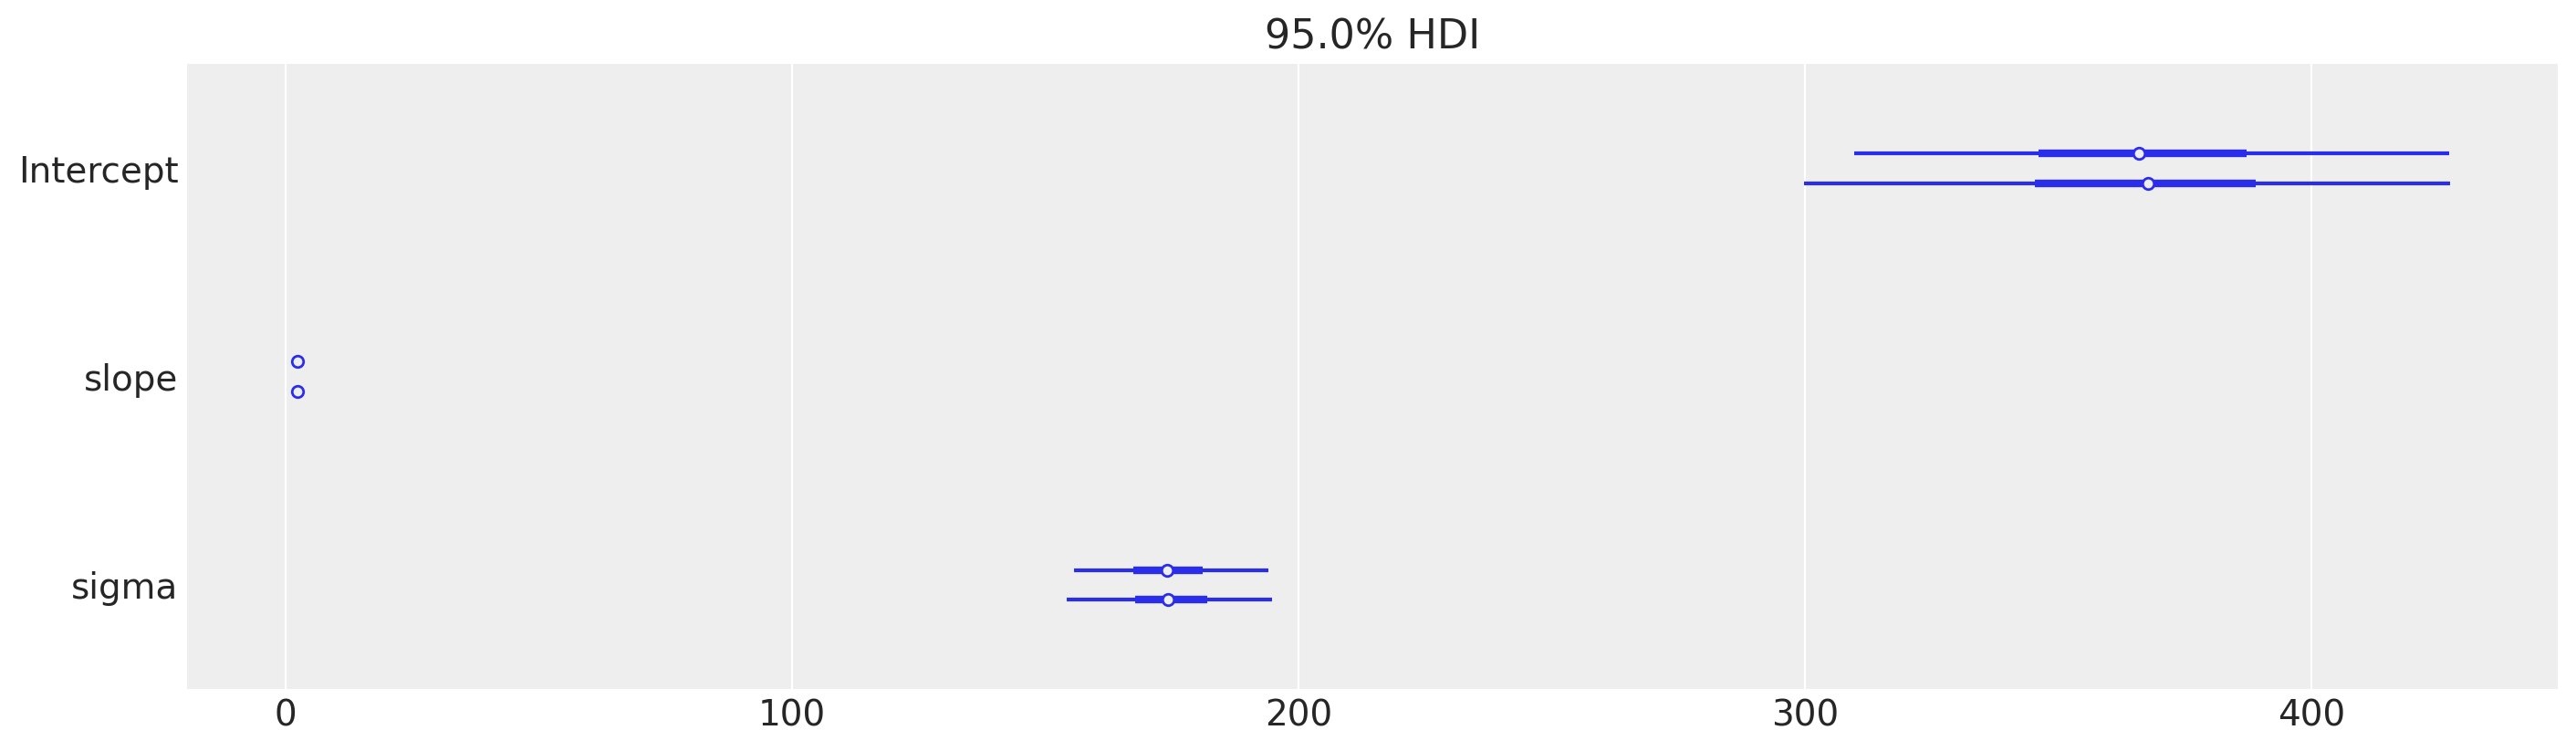

In [9]:
pm.plot_forest(trace1, hdi_prob = 0.95, figsize = (14,4));

Following: https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/GLM_linear.html

In [125]:
xtrain=xr.DataArray(data_train["x"])
trace1.posterior["ytrain_model"] = trace1.posterior["Intercept"] + trace1.posterior["slope"] * xtrain


C:\Users\Hossein\anaconda3\lib\site-packages\arviz\plots\lmplot.py:211: UserWarning:

posterior_predictive not found in idata



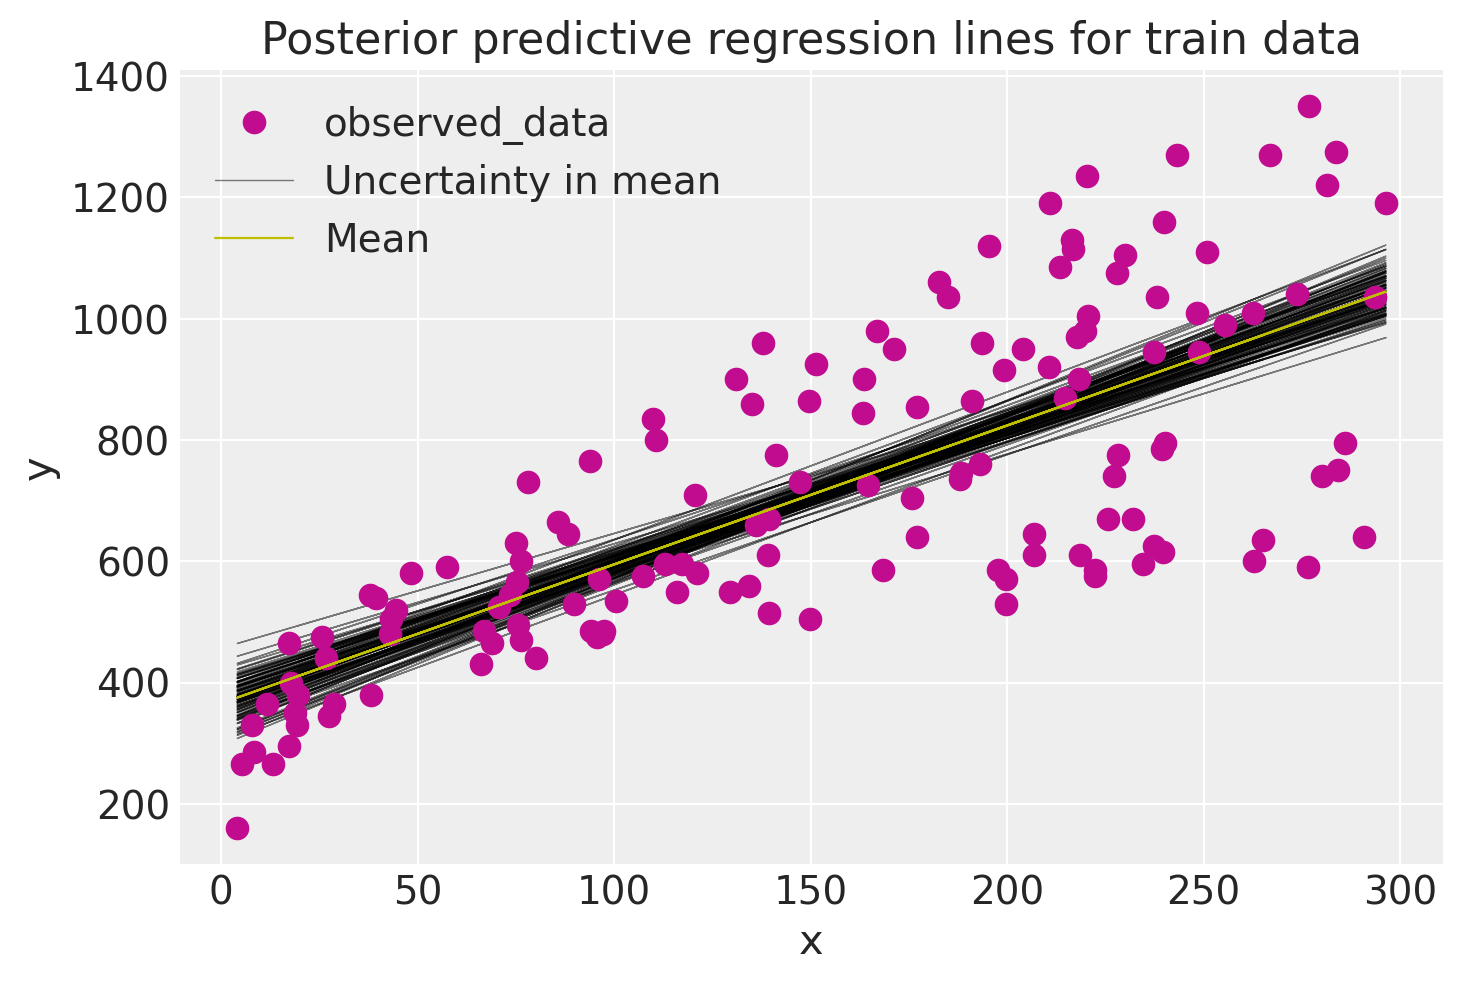

In [126]:
_, ax = plt.subplots()
az.plot_lm(idata=trace1, y="y", x=xtrain, num_samples=100, axes=ax, y_model="ytrain_model")
ax.set_title("Posterior predictive regression lines for train data");

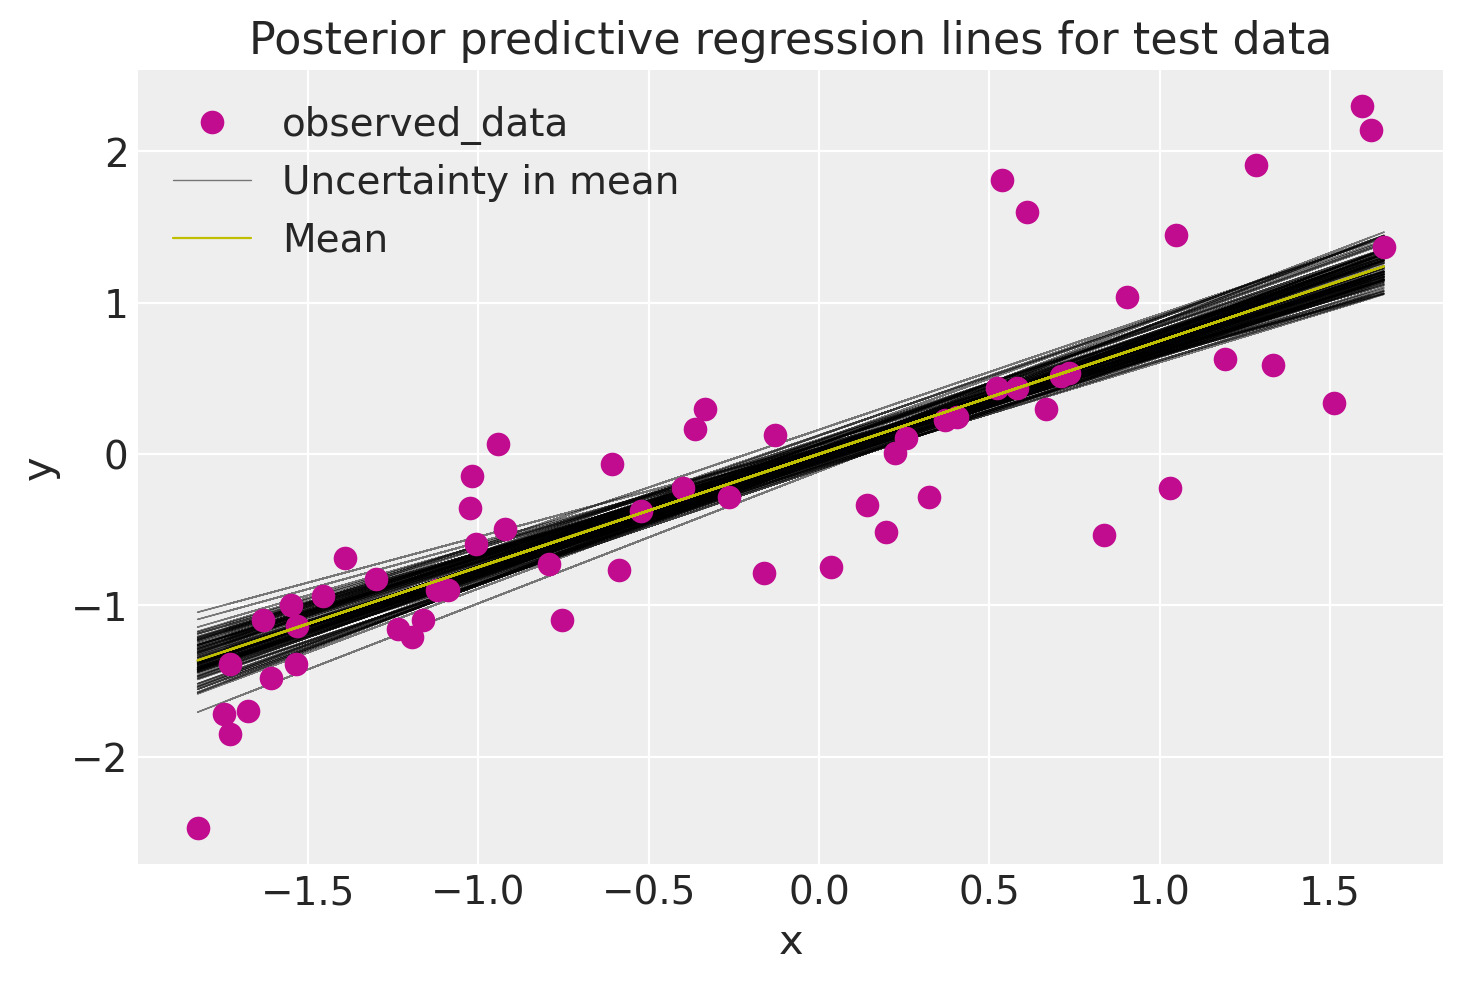

In [82]:
xtest=xr.DataArray(data_test["x"])
trace1.posterior["ytest_model"] = trace1.posterior["Intercept"] + trace1.posterior["slope"] * xtest

_, ax = plt.subplots()
az.plot_lm(idata=trace1, y=data_test["y"], x=xtest, num_samples=100, axes=ax, y_model="ytest_model")
ax.set_title("Posterior predictive regression lines for test data");

## Bambi

In [127]:
import bambi as bmb

model1_bambi = bmb.Model('y ~ x', data_train)
# Fit the model using 1000 on each of 1 chains
results1_bambi = model1_bambi.fit(draws=1000, chains=1) # chains=2 if it works on your computer

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [y_sigma, Intercept, x]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 11 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
Intercept  4.54  0.63    3.20     5.56       0.02     0.01   1099.65   
x          0.05  0.00    0.04     0.05       0.00     0.00   1028.04   
y_sigma    2.80  0.18    2.51     3.15       0.00     0.00   1408.14   

           ess_tail  r_hat  
Intercept    521.41    NaN  
x            615.37    NaN  
y_sigma      764.82    NaN

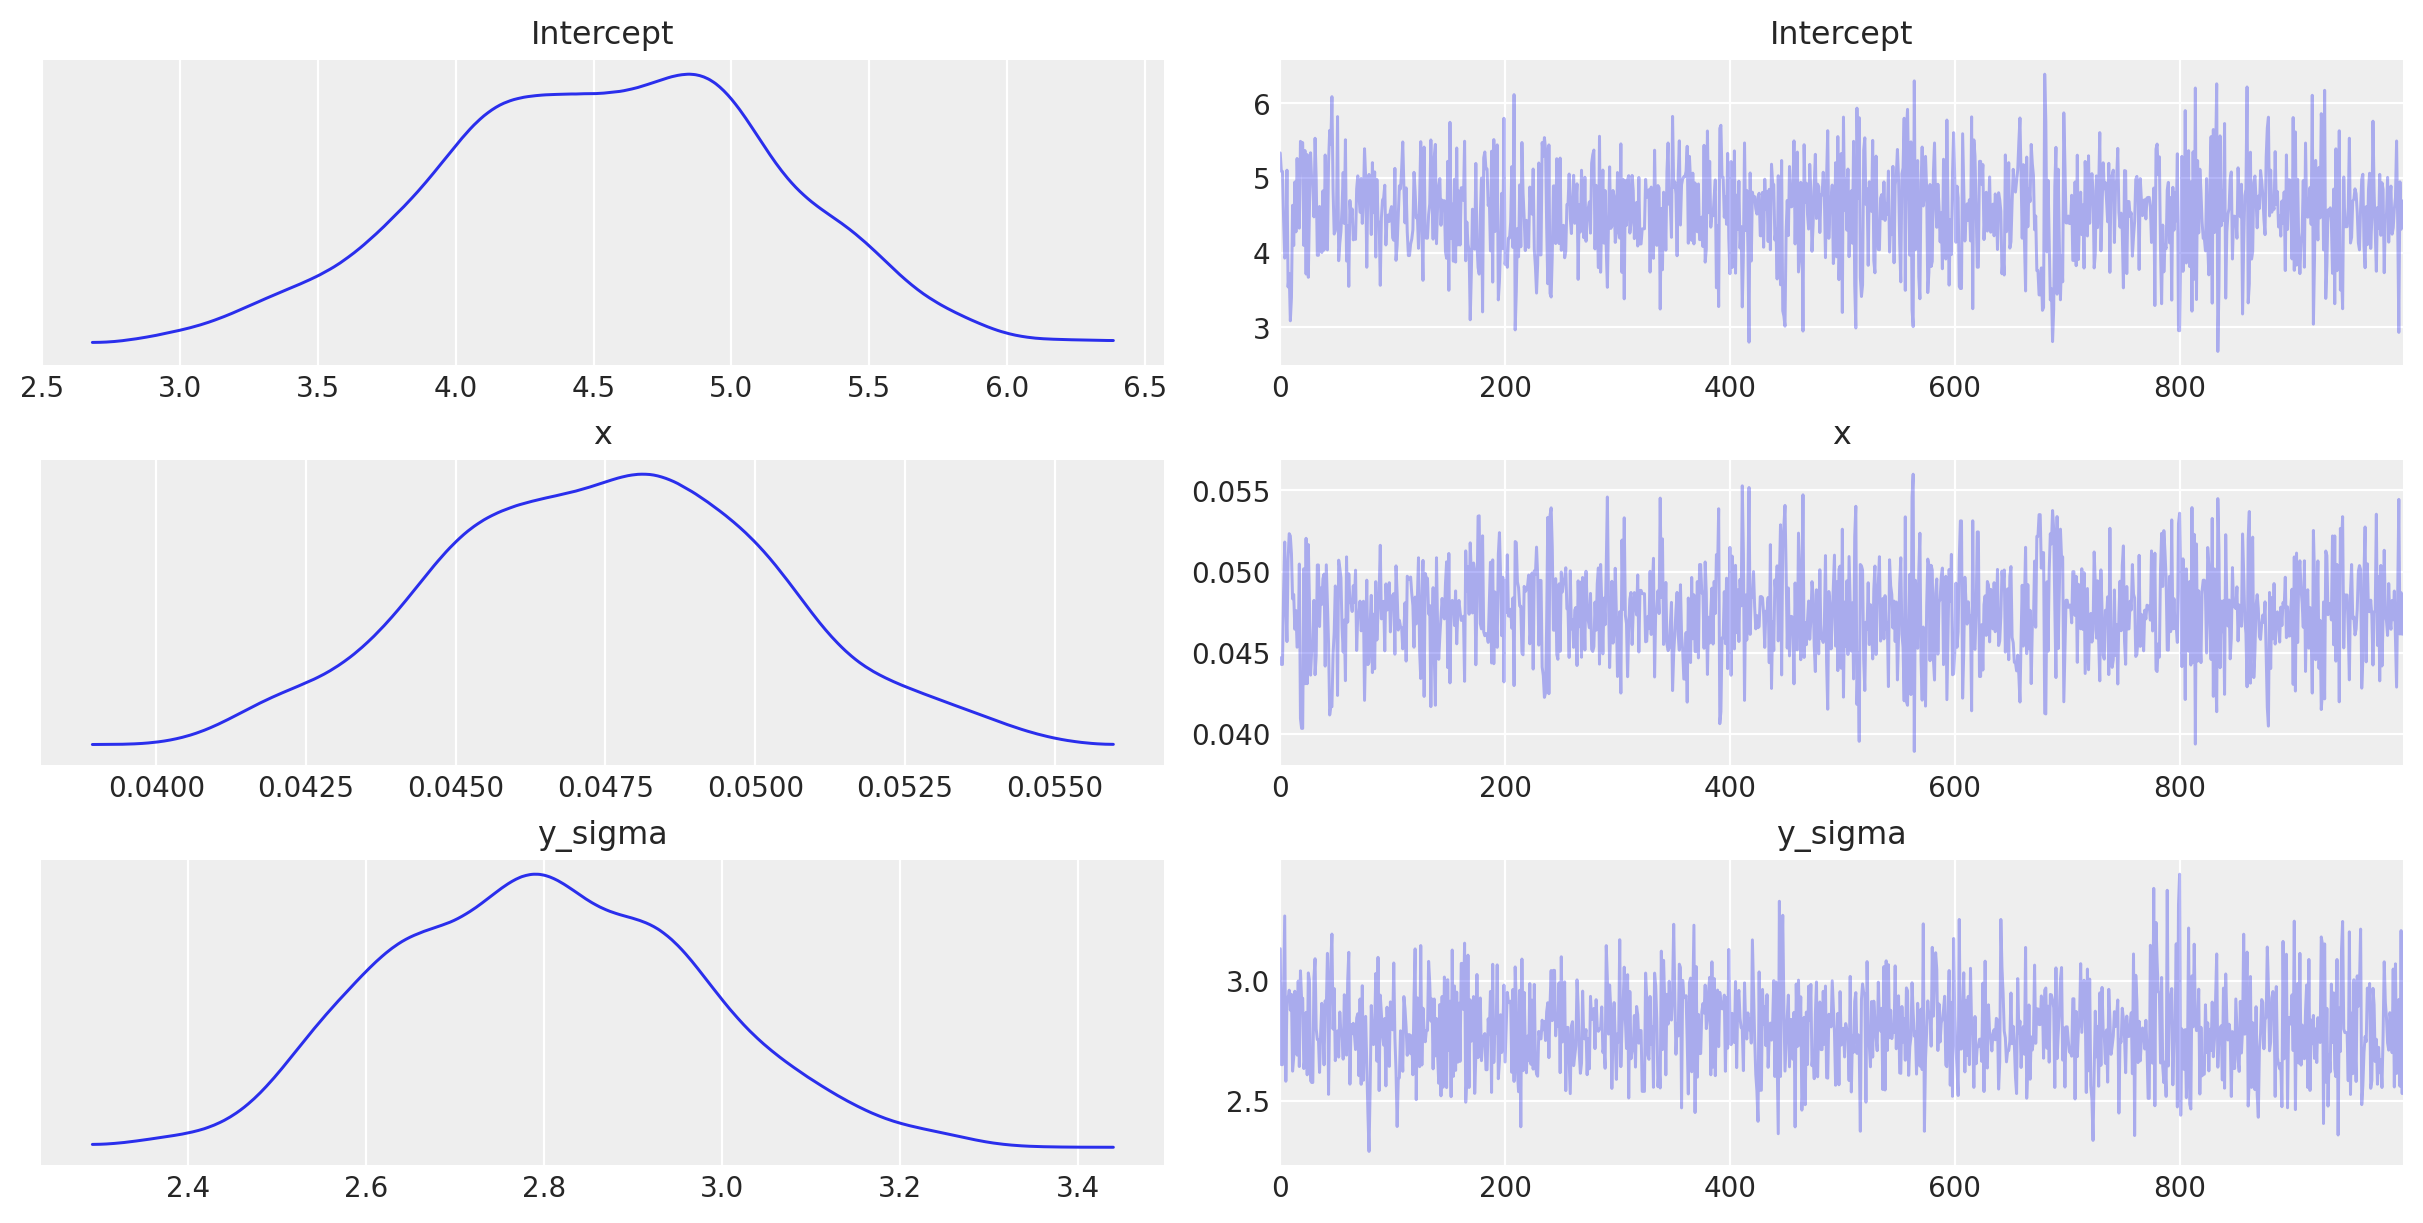

In [16]:
# Use ArviZ to plot the results
az.plot_trace(results1_bambi)

# Key summary and diagnostic info on the model parameters
az.summary(results1_bambi, round_to=2)

## Multiple (variable) linear regression

In [96]:
df=pd.read_csv('advertising.csv')
df=df.drop('Unnamed: 0',axis=1)
#df['Ads']= df[['TV Ad Budget ($)', 'Radio Ad Budget ($)', 'Newspaper Ad Budget ($)']].sum(axis=1)
# df.drop(['TV Ad Budget ($)','Radio Ad Budget ($)','Newspaper Ad Budget ($)'],axis=1,inplace=True)
# df.to_csv('allads.csv', index=False)
df

TV Ad Budget  Radio Ad Budget  Newspaper Ad Budget   Sales
0           230.1             37.8                 69.2  1105.0
1            44.5             39.3                 45.1   520.0
2            17.2             45.9                 69.3   465.0
3           151.5             41.3                 58.5   925.0
4           180.8             10.8                 58.4   645.0
..            ...              ...                  ...     ...
195          38.2              3.7                 13.8   380.0
196          94.2              4.9                  8.1   485.0
197         177.0              9.3                  6.4   640.0
198         283.6             42.0                 66.2  1275.0
199         232.1              8.6                  8.7   670.0

[200 rows x 4 columns]

In [134]:

xmulti = df.iloc[:, 0:2] # ads
y = df.iloc[:, 3] # sales

xmulti_train, xmulti_test, y_train, y_test = train_test_split(xmulti, y, test_size=0.3, random_state=0)

datamulti_train = pd.concat([xmulti_train, y_train], axis=1)
datamulti_train = datamulti_train.rename(columns={'TV Ad Budget': 'x1', 'Radio Ad Budget': 'x2', 'Sales': 'y'})
datamulti_train

x1    x2       y
131  265.2   2.9   635.0
96   197.6   3.5   585.0
181  218.5   5.4   610.0
19   147.3  23.9   730.0
153  171.3  39.7   950.0
..     ...   ...     ...
67   139.3  14.5   670.0
192   17.2   4.1   295.0
117   76.4   0.8   470.0
47   239.9  41.5  1160.0
172   19.6  20.1   380.0

[140 rows x 3 columns]

In [135]:


with pm.Model() as model2:
    # prior distributions: Gaussian with very large variance
    intercept = pm.Normal('Intercept', 0, 1000) # model b0 - Intercept Prior
    slope1 = pm.Normal('slope1', 0, 1000)         # model b1 - Slope Prior 
    slope2 = pm.Normal('slope2', 0, 1000)         # model b2 - Slope Prior
    sigma = pm.HalfNormal('sigma', 1000)             # standard deviation
    
    # specify the model, linear regression
    x1 = pm.MutableData("x1", datamulti_train["x1"])  
    x2 = pm.MutableData("x2", datamulti_train["x2"]) 
    mu = intercept + slope1 * x1 +slope2 * x2               # estimate of model
    y_obs= datamulti_train["y"]
    
    # define the distribution of the predictions from the model and provide the data
    likelihood = pm.Normal('y', mu = mu, sigma = sigma, observed = y_obs) # Observed values
    
    trace2=pm.sample(1000, chains=2, cores=2)
    
    # specify the sampler
    #step = pm.NUTS()#(target_accept = 0.95) # use the No-U-Turn Sampler (NUTS) for Markov Chains Monte Carlo MCMC, addaptive step size

    # Posterior distribution
    #linear_trace_all_data = pm.sample(draws = 500, tune = 500, step = step, random_seed = seed, return_inferencedata = True)
    #linear_trace_all_data = pm.sample(draws = 500, tune = 500, step = step, random_seed = seed, 
    #                                  discard_tuned_samples = False,return_inferencedata=True)
pm.summary(trace2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Intercept, slope1, slope2, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 79 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


mean      sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
Intercept  144.454  17.476  110.420  175.471      0.554    0.392     992.0   
slope1       2.201   0.081    2.047    2.349      0.002    0.002    1107.0   
slope2      10.072   0.443    9.226   10.826      0.012    0.008    1426.0   
sigma       80.624   5.043   70.811   89.462      0.131    0.093    1501.0   

           ess_tail  r_hat  
Intercept    1188.0    1.0  
slope1       1131.0    1.0  
slope2       1284.0    1.0  
sigma         905.0    1.0

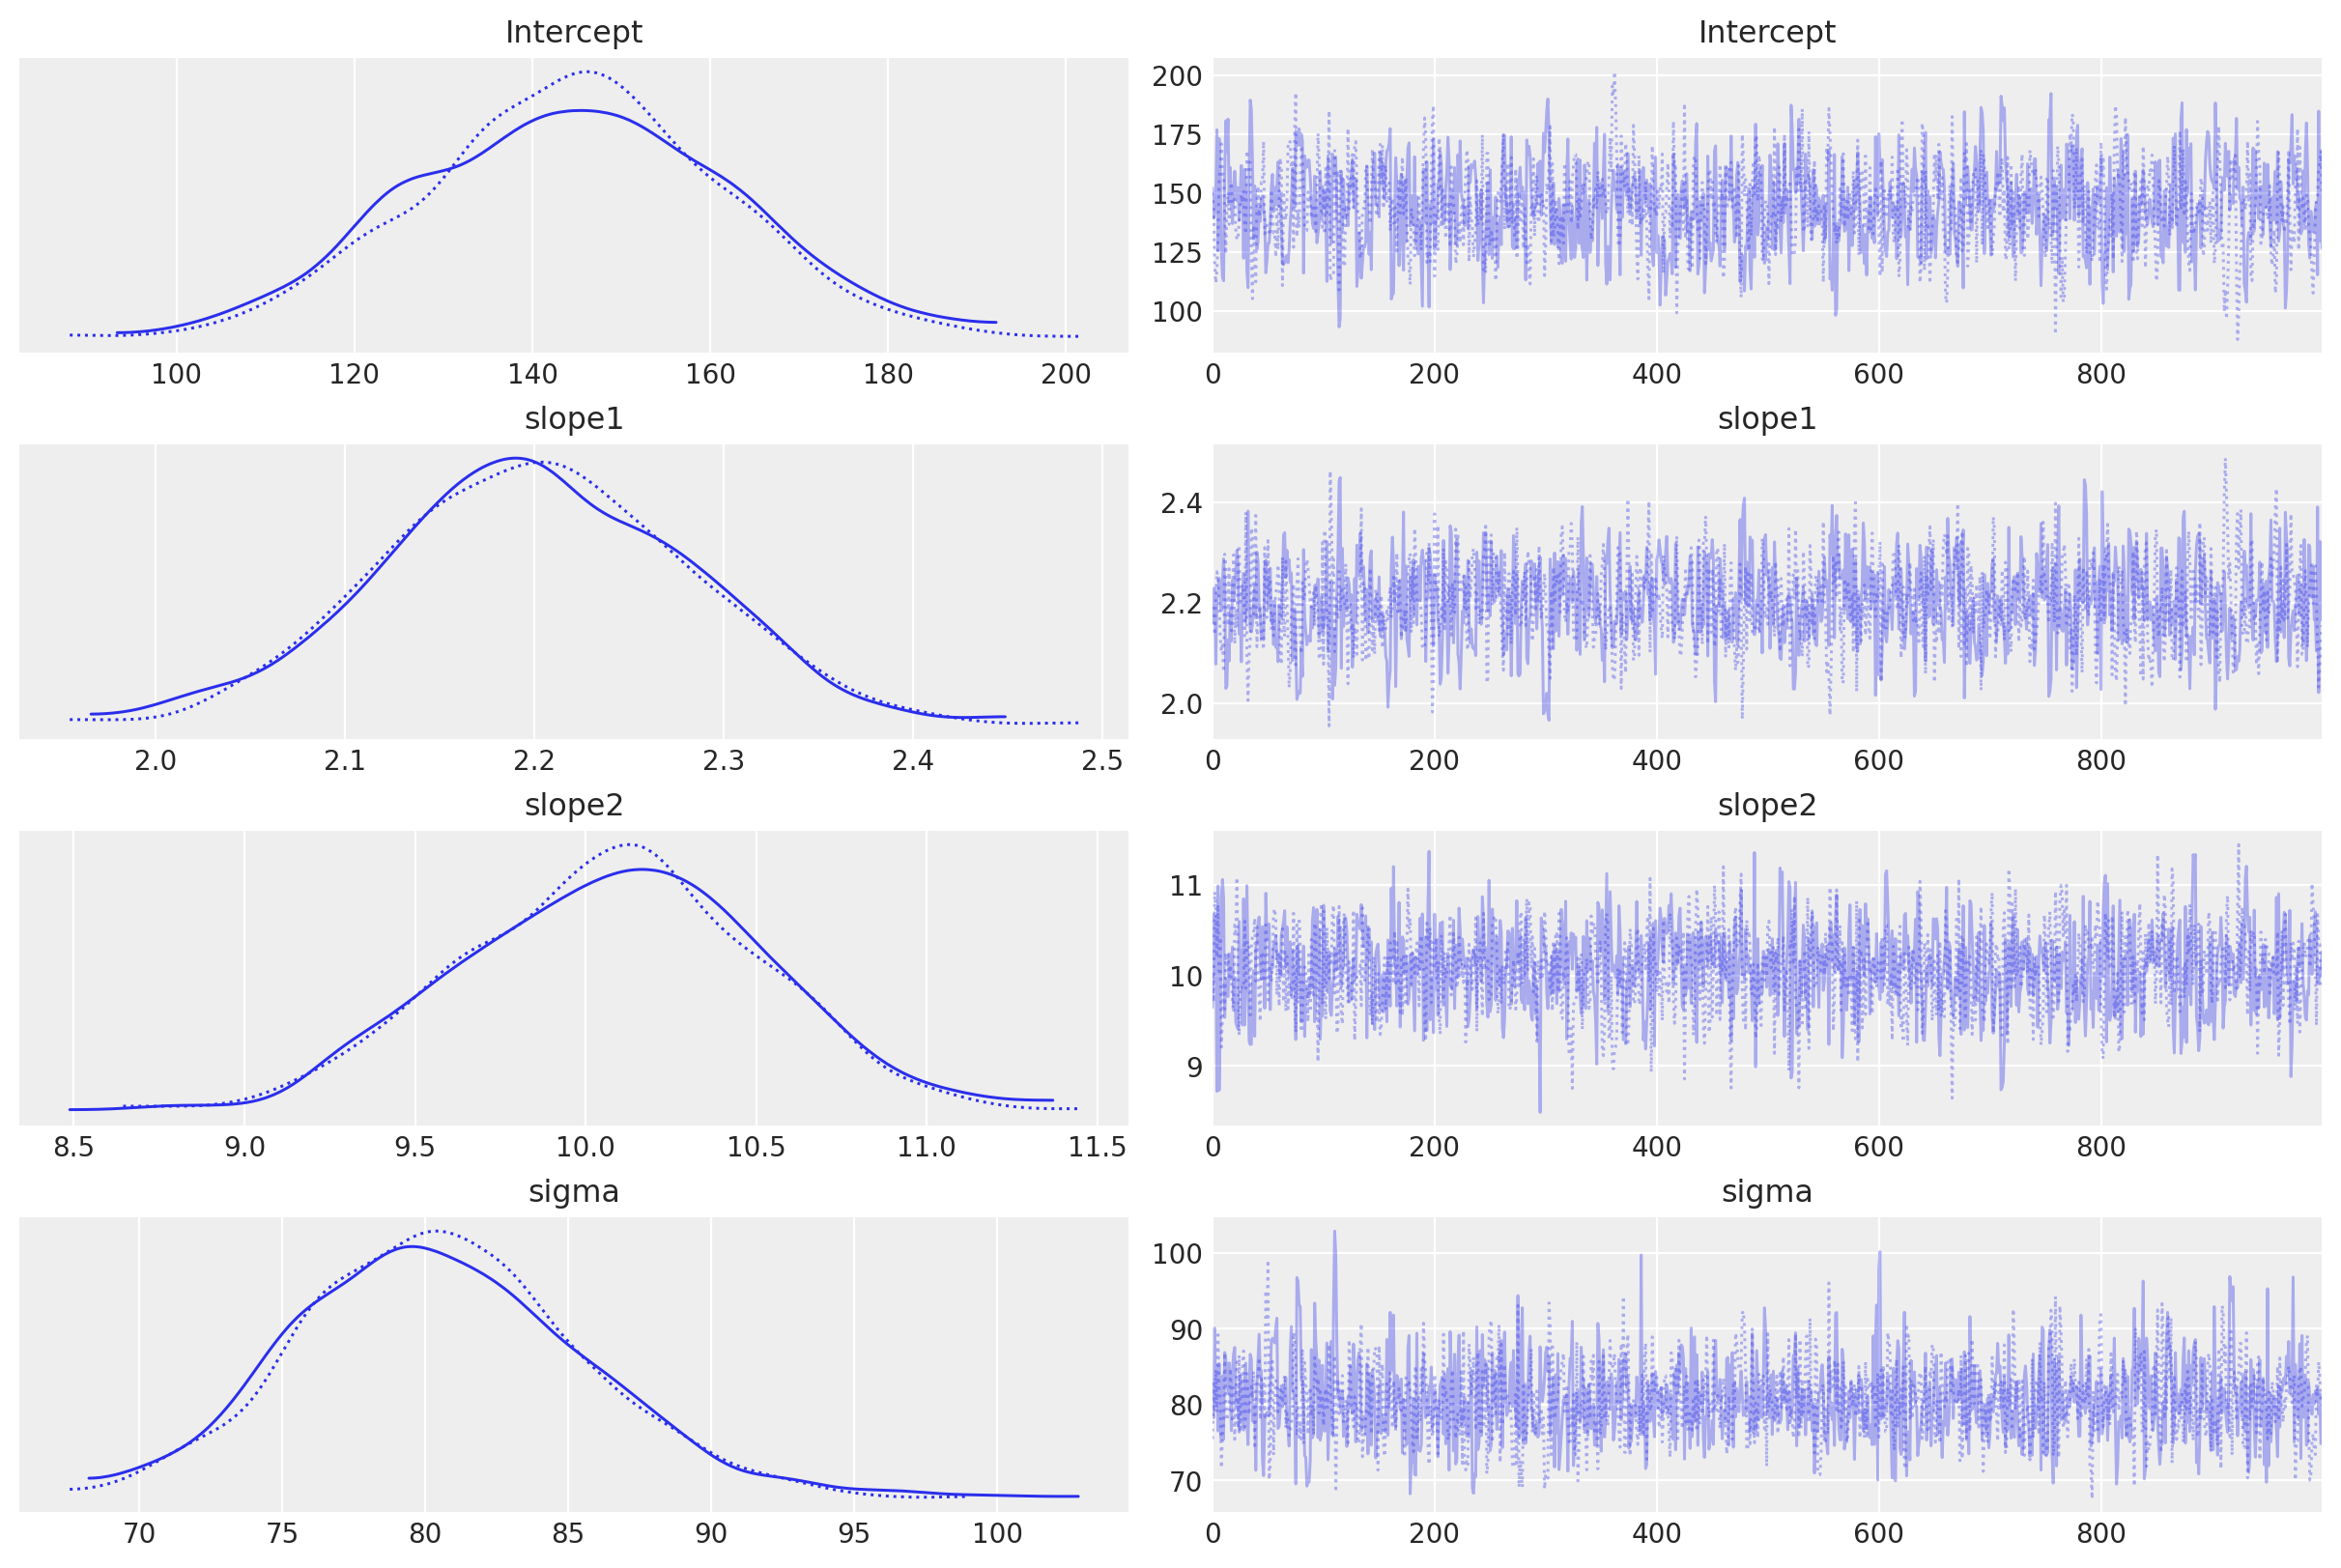

In [136]:
# Use ArviZ to plot the results
az.plot_trace(trace2);


In [138]:
with model1:
    pm.compute_log_likelihood(trace1)

In [137]:
with model2:
    pm.compute_log_likelihood(trace2)

In [139]:
model2_waic = az.waic(trace2)
model1_waic = az.waic(trace1)
print('model1_waic',model1_waic)
print('model2_waic',model2_waic)

model1_waic Computed from 2000 posterior samples and 140 observations log-likelihood matrix.

          Estimate       SE
elpd_waic  -922.24     7.36
p_waic        2.75        -
model2_waic Computed from 2000 posterior samples and 140 observations log-likelihood matrix.

          Estimate       SE
elpd_waic  -814.83     8.43
p_waic        5.02        -

There has been a warning during the calculation. Please check the results.


C:\Users\Hossein\anaconda3\lib\site-packages\arviz\stats\stats.py:1645: UserWarning:

For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details



In [142]:
df_comp_waic=az.compare({"model2": trace2, "model1": trace1}, ic="waic")
df_comp_waic

C:\Users\Hossein\anaconda3\lib\site-packages\arviz\stats\stats.py:1645: UserWarning:

For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details



rank   elpd_waic    p_waic   elpd_diff  weight        se       dse  \
model2     0 -814.833092  5.016947    0.000000     1.0  8.429108  0.000000   
model1     1 -922.235237  2.751670  107.402145     0.0  7.361445  9.544977   

        warning scale  
model2     True   log  
model1    False   log

In [141]:
df_comp_loo=az.compare({"model2": trace2, "model1": trace1}, ic="loo")
df_comp_loo

rank    elpd_loo     p_loo   elpd_diff  weight        se      dse  \
model2     0 -814.853863  5.037718    0.000000     1.0  8.432431  0.00000   
model1     1 -922.243058  2.759491  107.389195     0.0  7.362145  9.54717   

        warning scale  
model2    False   log  
model1    False   log

## Bambi multivariable

In [143]:
model2_bambi = bmb.Model('y ~ x1 + x2', datamulti_train)
# Fit the model using 1000 on each of 1 chains
results2_bambi = model2_bambi.fit(draws=1000, chains=2, cores=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [y_sigma, Intercept, x1, x2]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 67 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
Intercept  145.83  17.37  111.40   175.31       0.33     0.24   2772.17   
x1           2.20   0.08    2.05     2.36       0.00     0.00   2764.73   
x2          10.04   0.45    9.25    10.92       0.01     0.01   2991.43   
y_sigma     80.58   4.99   71.70    90.11       0.09     0.07   3026.43   

           ess_tail  r_hat  
Intercept   1259.28    1.0  
x1          1285.11    1.0  
x2          1606.64    1.0  
y_sigma     1581.15    1.0

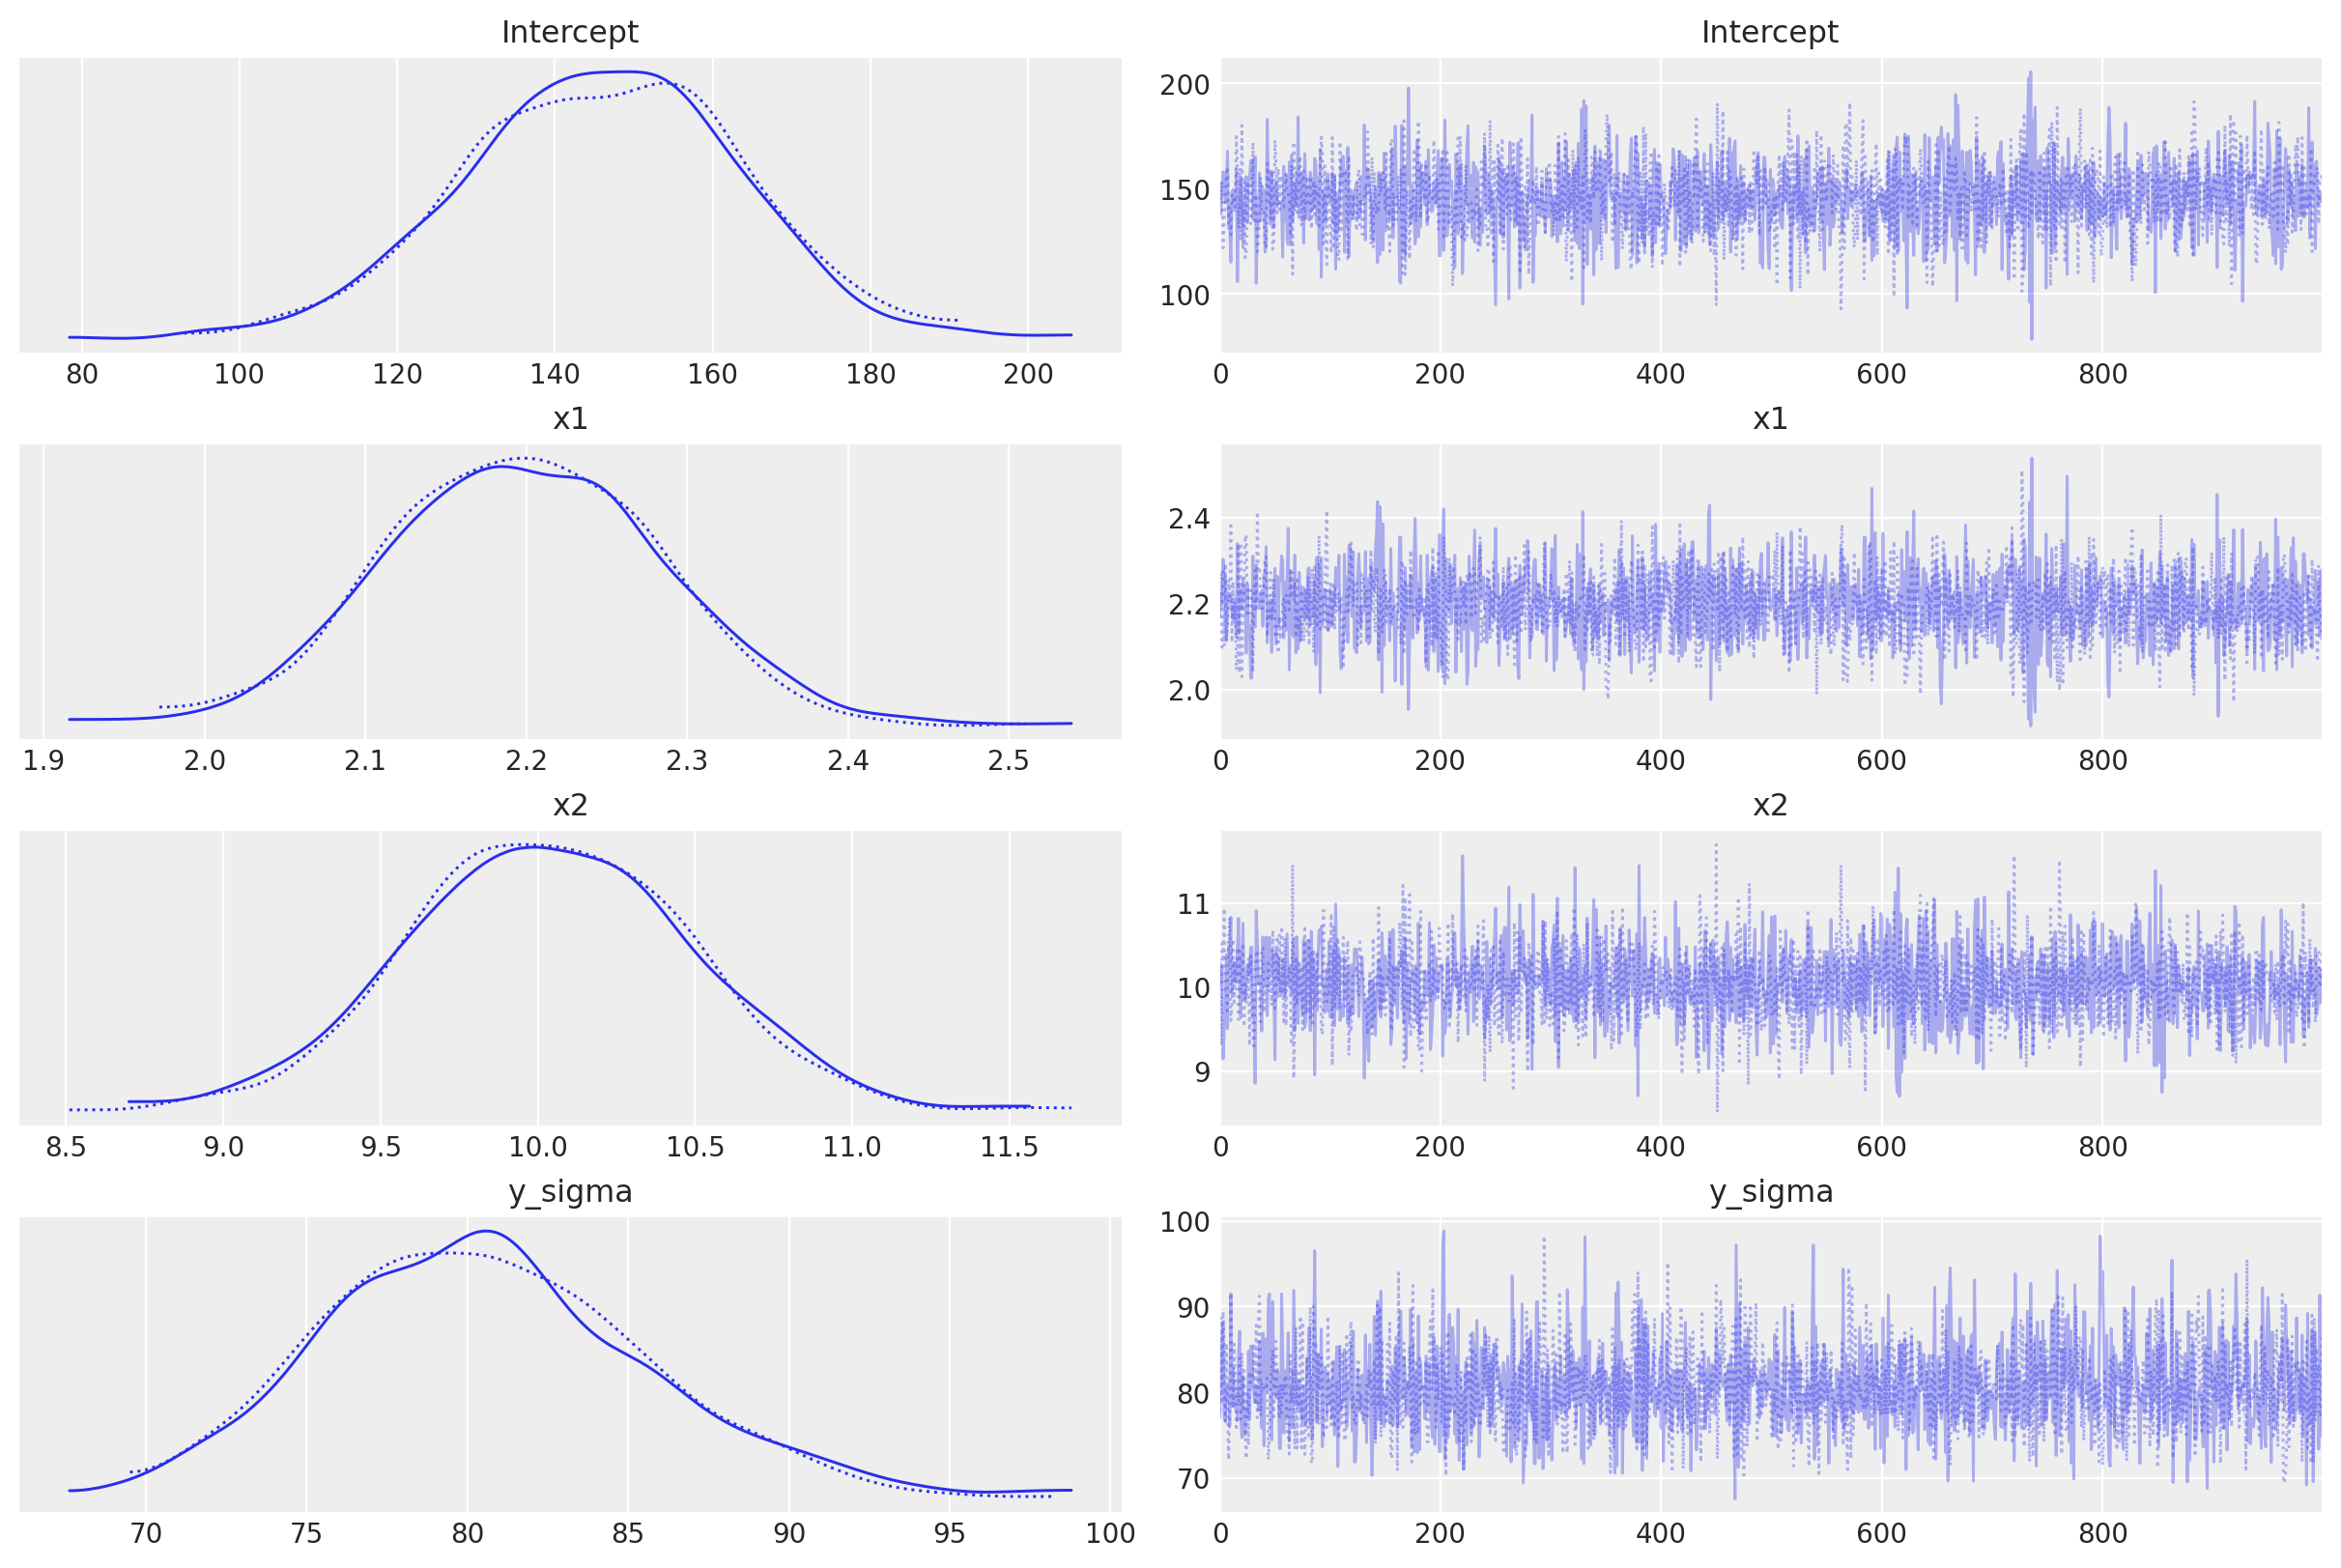

In [144]:
# Use ArviZ to plot the results
az.plot_trace(results2_bambi)

# Key summary and diagnostic info on the model parameters
az.summary(results2_bambi, round_to=2)

In [ ]:
#crear histograma para cada variable columna
